# Image in-painting
- guess pixel values in obscured/corrupted parts of image
- *total variation in-painting*:  choose pixel values $x_{i,j} \in \mathbf{R}^3$ to minimize
$$
\mbox{TV}(x) = \sum_{i,j} \left\| \left[ \begin{array}{c}
x_{i+1,j}-x_{i,j}\\
x_{i,j+1}-x_{i,j}
\end{array}\right]\right\|_2
$$
- a convex problem


# Example
- $600 \times 512$ color image
- denote corrupted pixels with $K \in \{0,1\}^{600 \times 512}$
    - $K_{ij} = 1$ if pixel value is known
    - $K_{ij} = 0$ if unknown

- $X_\mathrm{corr} \in \mathbf{R}^{600 \times 512 \times 3}$ is corrupted image
- 60 seconds to solve with CVXPY and SCS on a laptop

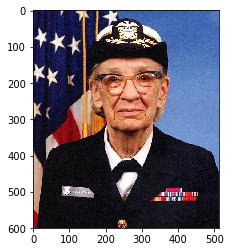

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib
import numpy as np
%matplotlib inline
cbook.get_sample_data('grace_hopper.png')
image_file = cbook.get_sample_data('grace_hopper.png')
X_orig = plt.imread(image_file)
plt.imshow(X_orig)

In [0]:
from PIL import Image, ImageDraw, ImageFont
import itertools, textwrap
from itertools import cycle, islice

def drawText(image, fontsize, length):
    text = 'Lorem ipsum dolor sit amet, consectetuer adipiscing elit, \
sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna \
aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud \
exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea \
commodo consequat. Duis autem vel eum iriure dolor in hendrerit in \
vulputate velit esse molestie consequat, vel illum dolore eu feugiat \
nulla facilisis at vero eros et accumsan et iusto odio dignissim qui \
blandit praesent luptatum zzril delenit augue duis dolore te feugait \
nulla facilisi. Nam liber tempor cum soluta nobis eleifend option \
congue nihil imperdiet doming id quod mazim placerat facer possim'
    
    imshape = (image.shape[0], image.shape[1])
    dmg = Image.new("L",imshape)
    draw = ImageDraw.Draw(dmg)

    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', fontsize)
    text = "".join(islice(cycle(text),length))
    lines = textwrap.wrap(text, width = 40)
    w, h = dmg.size
    y_text = 0
    for line in lines:
        width, height = font.getsize(line)
        draw.text((0, y_text), line, font = font, fill = 255)
        y_text += height
    
    return (np.array(dmg) == 0).astype(int)

(600, 512, 3)
(600, 512, 3)
(600, 512)


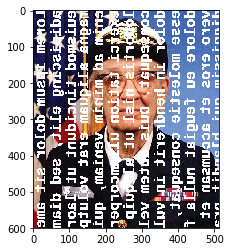

In [0]:
K = drawText(X_orig,40,600).T
rows, cols, colors = X_orig.shape

X_corr = np.ones((rows,cols,colors))
print(X_corr.shape)
print(X_orig.shape)
print(K.shape)
X_corr[K==1,:] = X_orig[K==1,:]
plt.imshow(X_corr)

In [0]:
%%time
from cvxpy import *
variables = []
constr = []
for i in range(colors):
    X = Variable((rows, cols))
    variables += [X]
    constr += [multiply(K, X - X_corr[:, :, i]) == 0]

prob = Problem(Minimize(tv(*variables)), constr)
prob.solve(verbose=True, solver=SCS,max_iters=500)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 4657595
eps = 1.00e-05, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1227689, constraints m = 3064223
Cones:	primal zero / dual free vars: 921600
	soc vars: 2142623, soc blks: 306089
Setup time: 2.45e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.40e+22  1.79e+22  1.00e+00 -1.46e+27  1.25e+26  3.55e+26  9.82e-01 
   100| 8.93e-04  1.62e-03  4.09e-04  2.11e+04  2.11e+04  1.89e-12  1.18e+02 
----------------------------------------------------------

In [0]:
# the recovered image
X_rec = np.zeros((rows,cols,3))
for i,x in enumerate(variables):
    X_rec[:,:,i] = x.value

In [0]:
def showImgs(im1,im2,labels,filename=None):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
    matplotlib.rcParams.update({'font.size': 14})
    fig.tight_layout()
    ax[0].imshow(im1)
    ax[1].imshow(im2)

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title(labels[0])
    ax[1].set_title(labels[1])

    if filename:
        fig.savefig(filename, bbox_inches='tight')

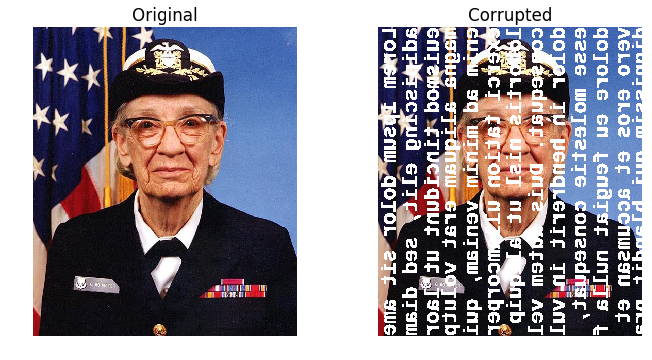

In [0]:
showImgs(X_orig,X_corr,['Original','Corrupted'],filename='inpaint_text1.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


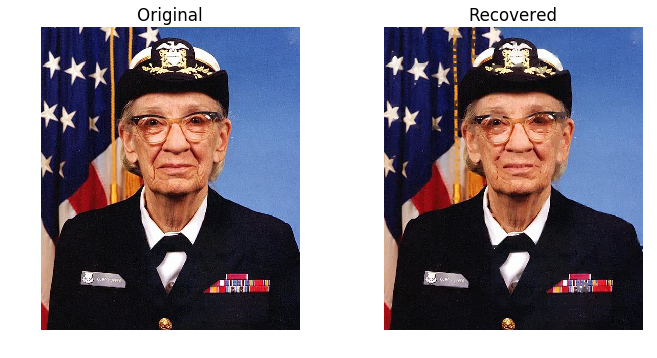

In [0]:
showImgs(X_orig,X_rec,['Original','Recovered'],filename='inpaint_text2.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


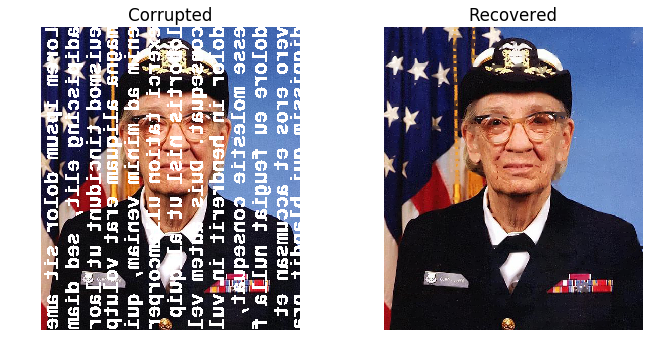

In [0]:
showImgs(X_corr,X_rec,['Corrupted','Recovered'],filename='inpaint_text_cr.pdf')

# Random pixels

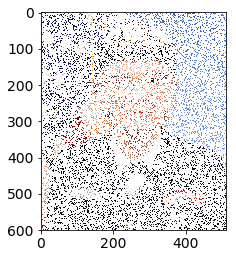

In [0]:
rows, cols, colors = X_orig.shape
K = (np.random.rand(rows,cols) < .2).astype(int)

X_corr = np.ones((rows,cols,colors))
X_corr[K==1,:] = X_orig[K==1,:]
plt.imshow(X_corr)

In [0]:
%%time
from cvxpy import *
variables = []
constr = []
for i in range(colors):
    X = Variable((rows, cols))
    variables += [X]
    constr += [multiply(K, X - X_corr[:, :, i]) == 0]

prob = Problem(Minimize(tv(*variables)), constr)
prob.solve(verbose=True, solver=SCS,max_iters=500)

WARN: A->p (column pointers) not strictly increasing, column 613288 empty
WARN: A->p (column pointers) not strictly increasing, column 920488 empty
WARN: A->p (column pointers) not strictly increasing, column 1227688 empty
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 4163141
eps = 1.00e-05, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1227689, constraints m = 3064223
Cones:	primal zero / dual free vars: 921600
	soc vars: 2142623, soc blks: 306089
Setup time: 2.45e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
--------------------------------------------------------------------

In [0]:
# the recovered image
X_rec = np.zeros((rows,cols,3))
for i,var in enumerate(variables):
    X_rec[:,:,i] = var.value

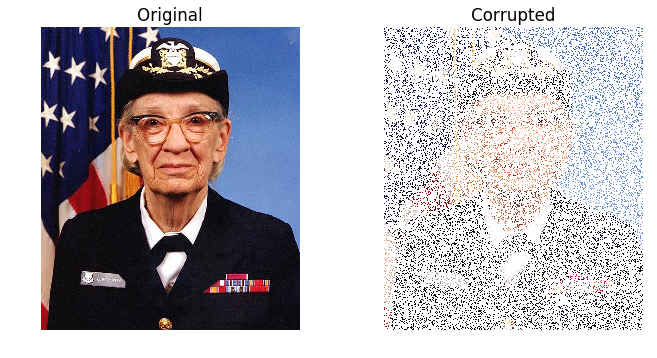

In [0]:
showImgs(X_orig,X_corr,['Original','Corrupted'],filename='inpaint80_1.pdf')

In [0]:
showImgs(X_orig,X_rec,['Original','Recovered'],filename='inpaint80_2.pdf')